In [1]:
from racecar_parse import *
import pygeodesy

In [2]:
# Import ROS2 Types
abs_msg_list = absoluteFilePaths('../novatel_gps_driver/novatel_oem7_msgs/msg')
msg_list = os.listdir('../novatel_gps_driver/novatel_oem7_msgs/msg')
add_types = {}

for pathstr in abs_msg_list:
    msgpath = Path(pathstr)
    msgdef = msgpath.read_text(encoding='utf-8')
    add_types.update(get_types_from_msg(msgdef, guess_msgtype(msgpath)))

register_types(add_types)
from rosbags.typesys.types import novatel_oem7_msgs__msg__BESTPOS as BESTPOS
from rosbags.typesys.types import novatel_oem7_msgs__msg__BESTVEL as BESTVEL
from rosbags.typesys.types import novatel_oem7_msgs__msg__Oem7Header as Oem7Header
from rosbags.typesys.types import nav_msgs__msg__Odometry as Odometry
from rosbags.typesys.types import geometry_msgs__msg__PoseWithCovariance as PoseWithCovariance
from rosbags.typesys.types import geometry_msgs__msg__TwistWithCovariance as TwistWithCovariance
from rosbags.typesys.types import geometry_msgs__msg__Pose as Pose
from rosbags.typesys.types import geometry_msgs__msg__Point as Point
from rosbags.typesys.types import geometry_msgs__msg__Quaternion as Quaternion
from rosbags.typesys.types import geometry_msgs__msg__Twist as Twist
from rosbags.typesys.types import geometry_msgs__msg__Vector3 as Vector3

In [32]:
# Generate Local Odom
def gen_local_odom(gps_messages, vel_messages, track):

    deg2rad = math.pi/180.0

    local_odom_arr = []
    if track == 'ims':
        origin = (39.795398310617, -86.23476471193612, 223)
    elif track == 'lvms':
        origin = (36.272371177449344, -115.01030828834901, 594)
    gpsmap = pygeodesy.LocalCartesian(origin[0], origin[1], origin[2])

    prev_pos = [0.0,0.0,0.0]
    prev_time = gps_messages[0][0]-10000

    for ros_time, bestpos in tqdm(gps_messages):

        
        bestvel = None

        ros_time_vel = 0

        # Parse BESTPOS

        ros_header = bestpos.header
        ros_frame  = ros_header.frame_id
        gps_header = bestpos.nov_header
        gps_time   = gps_header.gps_week_milliseconds
        lat        = bestpos.lat
        lon        = bestpos.lon
        hgt        = bestpos.hgt
        lat_stdev  = bestpos.lat_stdev  
        lon_stdev  = bestpos.lon_stdev  
        hgt_stdev  = bestpos.hgt_stdev

        novel = True
        # Find Corresponding BESTVEL
        for time,msg in vel_messages:
            if msg.nov_header.gps_week_milliseconds == gps_time:
                ros_time_vel = time
                bestvel = msg
                novel = False
                break
            if msg.nov_header.gps_week_milliseconds > gps_time:
                break 
        

        # GPS 2 LOCAL CARTESIAN
        local_tuple = gpsmap.forward(lat, lon, hgt)
        if novel:
            heading = math.atan2(local_tuple[1] - prev_pos[1], local_tuple[0] - prev_pos[0]) - math.pi/2
            hor_speed = (((local_tuple[1] - prev_pos[1])**2+(local_tuple[0] - prev_pos[0])**2)**(0.5))/(ros_time-prev_time)
            # quat    = R.from_euler('z',heading).as_quat()
        else:
            ros_header_v = bestvel.header
            gps_header_v = bestvel.nov_header
            gps_time_v   = gps_header_v.gps_week_milliseconds
            trk_gnd      = bestvel.trk_gnd
            latency      = bestvel.latency
            hor_speed    = bestvel.hor_speed
            ver_speed    = bestvel.ver_speed
            heading = -trk_gnd*deg2rad
        
        trk_r  = R.from_euler('z',heading)
        base_r = R.from_euler('z', math.pi/2)
        quat = (trk_r*base_r).as_quat()
        
        
        rot_stdev = (math.pi/2*180)

        

        prev_pos[0] = local_tuple[0]
        prev_pos[1] = local_tuple[1]
        prev_pos[2] = local_tuple[2]
        
        prev_time   =  ros_time
        
        
        ros_header.frame_id = 'map'
        # Populate Odom Message
        gps_to_ramg : np.ndarray = np.eye(4)
        gps_to_ramg[0,3]=-1.606
        maptogps : np.ndarray             = np.eye(4)
        maptogps[0:3,3]                   = np.asarray([local_tuple[0], local_tuple[1], local_tuple[2]])
        maptogps[0:3,0:3]                 = R.from_quat(np.asarray([quat[0], quat[1], quat[2], quat[3]])).as_matrix()
        ramg_pose : np.ndarray            = np.matmul(maptogps, gps_to_ramg)
        ramg_quat : np.ndarray            = R.from_matrix(ramg_pose[0:3,0:3]).as_quat()
        
        
        odom_point   = Point(x=ramg_pose[0,3],y=ramg_pose[1,3],z=ramg_pose[2,3])
        odom_quat    = Quaternion(x=ramg_quat[0],y=ramg_quat[1],z=ramg_quat[2],w=ramg_quat[3])
        linear_vel   = Vector3(x=hor_speed,y=0.0,z=0.0)
        angular_vel  = Vector3(x=0.0,y=0.0,z=0.0)
        odom_pose    = Pose(position=odom_point,orientation=odom_quat)
        odom_twist   = Twist(linear=linear_vel,angular=angular_vel)
        cov_pose     = np.zeros(36)
        cov_pose[0]  = lon_stdev*lon_stdev
        cov_pose[7]  = lat_stdev*lat_stdev
        cov_pose[14] = hgt_stdev*hgt_stdev
        cov_pose[21] = rot_stdev*rot_stdev
        cov_pose[28] = rot_stdev*rot_stdev
        cov_pose[35] = rot_stdev*rot_stdev
        cov_twist    = np.zeros(36)
        cov_twist[0] = .125*.125
        cov_twist[7] = .0025
        cov_twist[14]= .0025
        odom_posec   = PoseWithCovariance(pose=odom_pose,covariance=cov_pose)
        odom_twistc  = TwistWithCovariance(twist=odom_twist,covariance=cov_twist)
        
        local_odom = Odometry(header = ros_header,
                              child_frame_id = 'rear_axle_middle_ground',
                              pose = odom_posec,
                              twist= odom_twistc)

        local_odom_arr.append([ros_time, local_odom, gps_time])

    return local_odom_arr   

In [25]:
def write_merged_bag(ego_bag_file, target_bag, ego_namespace, obj_namespace, ego_odom, obj_odom, start_time, end_time):
    ego_sensors=[]
    conn_map = {}

    annotation_odom = []

    for odom1 in tqdm(ego_odom):
        for odom2 in obj_odom:
            if odom1[2] == odom2[2]:
                annotation_odom.append([odom1[0],odom2[1]])
                continue

    with Reader(ego_bag_file) as reader, Writer(target_bag) as writer:
        for connection in reader.connections:
            if (connection.topic == '/tf'):
                continue
            ego_sensors.append(connection.topic)
            conn_map[connection.id] = writer.add_connection('{}'.format(connection.topic), connection.msgtype, 'cdr', '')

        connections = [x for x in reader.connections if x.topic in ego_sensors]
        for connection, timestamp, rawdata in tqdm(reader.messages(connections=connections)):
            if ((timestamp*1e-9 > start_time) and timestamp*1e-9 < end_time):
                writer.write(conn_map[connection.id], timestamp, rawdata)
        
            
        # add new connection
        topic = '/{}/local_odometry'.format(ego_namespace)
        msgtype = Odometry.__msgtype__
        ego_connection = writer.add_connection(topic, msgtype, 'cdr', '')

        topic = '/{}/local_odometry'.format(obj_namespace)
        obj_connection = writer.add_connection(topic, msgtype, 'cdr', '')
        
        for odom in ego_odom:
            timestamp = odom[0]
            message = odom[1]
            writer.write(ego_connection, timestamp, serialize_cdr(message,msgtype))
        for odom in annotation_odom:
            timestamp = odom[0]
            message = odom[1]
            writer.write(obj_connection, timestamp, serialize_cdr(message,msgtype))

In [5]:
def write_solo_bag(ego_bag_file, target_bag, ego_namespace, ego_odom, start_time, end_time):
    ego_sensors=[]
    conn_map = {}

    with Reader(ego_bag_file) as reader, Writer(target_bag) as writer:
        for connection in reader.connections:
            if (connection.topic == '/tf'):
                continue
            ego_sensors.append(connection.topic)
            conn_map[connection.id] = writer.add_connection('{}'.format(connection.topic), connection.msgtype, 'cdr', '')

        connections = [x for x in reader.connections if x.topic in ego_sensors]
        for connection, timestamp, rawdata in tqdm(reader.messages(connections=connections)):
            if ((timestamp*1e-9 > start_time) and timestamp*1e-9 < end_time):
                writer.write(conn_map[connection.id], timestamp, rawdata)
        
            
        # add new connection
        topic = '/{}/local_odometry'.format(ego_namespace)
        msgtype = Odometry.__msgtype__
        ego_connection = writer.add_connection(topic, msgtype, 'cdr', '')
        
        for odom in ego_odom:
            timestamp = odom[0]
            message = odom[1]
            writer.write(ego_connection, timestamp, serialize_cdr(message,msgtype))

In [35]:
#MULTI-SLOW-MIT-KAIST

mit_bag_file = '../../data/RAW_ROSBAG/MIT-PITT-RW/LVMS/LVMS-MULTI-SLOW with KAIST/LVMS-MULTI-SLOW with KAIST'
kaist_bag_file = '../../data/RAW_ROSBAG/KAIST/LVMS/LVMS-MULTI-SLOW with MIT-PITT-RW/sensors_2022-01-02_14-20-08'
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

mit_gps_messages, mit_vel_messages = read_bag_file(mit_bag_file, topics)
kaist_gps_messages, kaist_vel_messages = read_bag_file(kaist_bag_file, topics)

mit_local_odom = gen_local_odom(mit_gps_messages, mit_vel_messages,'lvms')
kaist_local_odom = gen_local_odom(kaist_gps_messages, kaist_vel_messages,'lvms')

start_time = 1641163600.0
end_time = 1641164300.0
pruned_mit_odom = [mit_local_odom[i] for i, y in enumerate(mit_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
pruned_kaist_odom = [kaist_local_odom[i] for i, y in enumerate(kaist_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]

write_merged_bag(ego_bag_file=mit_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/MIT-PITT-RW/LVMS/MULTI-SLOW-KAIST-GPS',
                 ego_namespace='vehicle_8',
                 obj_namespace='vehicle_4',
                 ego_odom=pruned_mit_odom,
                 obj_odom=pruned_kaist_odom,
                 start_time=start_time,
                 end_time=end_time)

write_merged_bag(ego_bag_file=kaist_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/KAIST/LVMS/MULTI-SLOW-MIT-PITT-RW-GPS',
                 ego_namespace='vehicle_4',
                 obj_namespace='vehicle_8',
                 ego_odom=pruned_kaist_odom,
                 obj_odom=pruned_mit_odom,
                 start_time=start_time,
                 end_time=end_time)

54616it [00:05, 9426.82it/s] 
47367it [00:03, 13088.22it/s]
100%|██████████| 14000/14000 [00:43<00:00, 322.21it/s]
8506052it [07:40, 18482.04it/s]
100%|██████████| 14000/14000 [00:16<00:00, 856.03it/s]
6584498it [05:28, 20057.69it/s]


In [7]:
# TUM SOLO-FAST-140-170
tum_bag_file = '../../data/RAW_ROSBAG/TUM/LVMS/LVMS-FAST-140-170/perception_bag_202201072129'
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

tum_gps_messages, tum_vel_messages = read_bag_file(tum_bag_file, topics)
tum_local_odom = gen_local_odom(tum_gps_messages, tum_vel_messages)

start_time = 1641587975.0
end_time = 1641588600.0
pruned_tum_odom = [tum_local_odom[i] for i, y in enumerate(tum_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]

write_solo_bag(ego_bag_file=tum_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/TUM/LVMS/SOLO-FAST-140-170',
                 ego_namespace='vehicle_3',
                 ego_odom=pruned_tum_odom,
                 start_time=start_time,
                 end_time=end_time)

47054it [00:02, 22955.18it/s]
100%|██████████| 23527/23527 [02:34<00:00, 151.92it/s]
1562198it [03:30, 7418.66it/s] 


In [8]:
# Polimove SOLO-SLOW-70
poli_bag_file = '../../data/RAW_ROSBAG/PoliMove/LVMS/LVMS-SLOW-70/20211228_lvms_solo_slow_polimove'
topics = ['/novatel_top/bestgnsspos', '/novatel_top/bestvel']

poli_gps_messages, poli_vel_messages = read_bag_file(poli_bag_file, topics)
poli_local_odom = gen_local_odom(poli_gps_messages, poli_vel_messages)

start_time = 0.0
end_time = 2641588600.0
# pruned_tum_odom = [tum_local_odom[i] for i, y in enumerate(tum_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]

write_solo_bag(ego_bag_file=poli_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/PoliMove/LVMS/SOLO-SLOW-70',
                 ego_namespace='vehicle_5',
                 ego_odom=poli_local_odom,
                 start_time=start_time,
                 end_time=end_time)

49347it [00:02, 18624.75it/s]
100%|██████████| 24776/24776 [03:20<00:00, 123.78it/s]
483090it [03:15, 2469.29it/s]


In [9]:
#MIT LVMS-SLOW-70

mit_bag_file = '../../data/RAW_ROSBAG/MIT-PITT-RW/LVMS/LVMS-SLOW-70/LVMS-SLOW-70'
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

mit_gps_messages, mit_vel_messages = read_bag_file(mit_bag_file, topics)

mit_local_odom = gen_local_odom(mit_gps_messages, mit_vel_messages)

write_solo_bag(ego_bag_file=mit_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/MIT-PITT-RW/LVMS/SOLO-SLOW-70',
                 ego_namespace='vehicle_8',
                 ego_odom=mit_local_odom,
                 start_time=start_time,
                 end_time=end_time)

53517it [12:45, 69.93it/s] 
100%|██████████| 26758/26758 [03:55<00:00, 113.69it/s]
10404985it [04:36, 37663.05it/s]


25463it [00:01, 15946.08it/s]
50005it [00:02, 17934.78it/s]
100%|██████████| 25060/25060 [03:13<00:00, 129.21it/s]


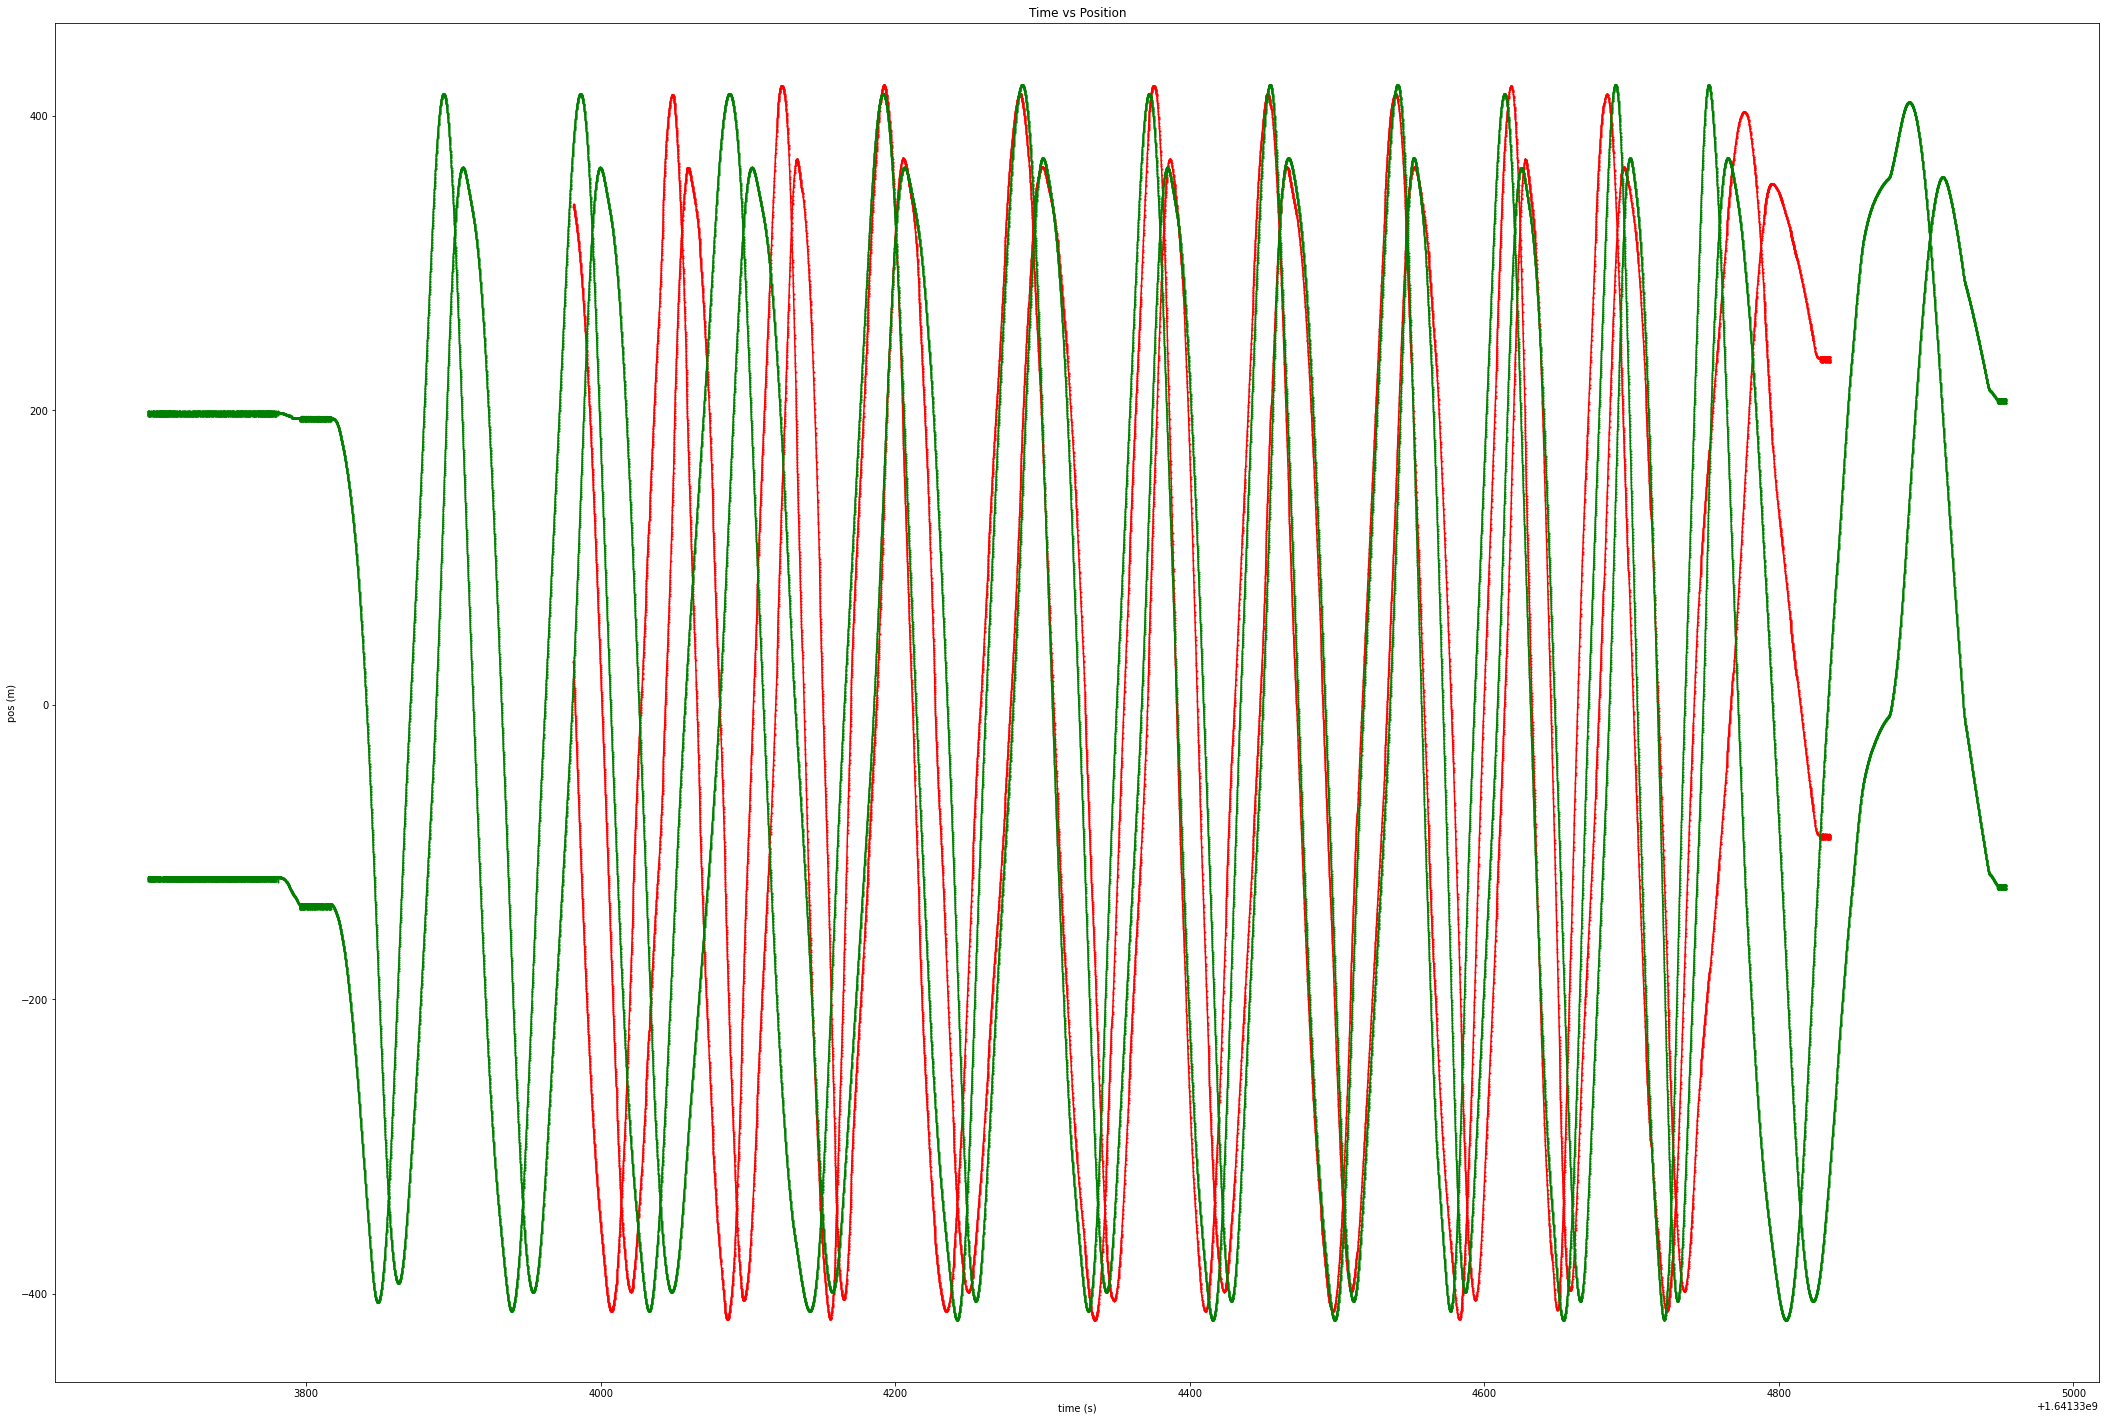

100%|██████████| 8348/8348 [00:09<00:00, 887.46it/s]
2330007it [02:17, 17006.35it/s] 
100%|██████████| 11909/11909 [00:09<00:00, 1191.28it/s]
491809it [01:36, 5079.74it/s] 


In [33]:

cav_bag_file = '../../data/RAW_ROSBAG/Cavalier/cavalier/rosbag2_2022_01_04-17_06_21'
poli_bag_file = '../../data/RAW_ROSBAG/PoliMove/LVMS/LVMS-MULTI-SLOW with Cavalier/20220104_lvms_multi_polimove_01_OK'
poli_topics = ['/novatel_top/bestgnsspos', '/novatel_top/bestvel']
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

cav_gps_messages, cav_vel_messages = read_bag_file(cav_bag_file, topics)
poli_gps_messages, poli_vel_messages = read_bag_file(poli_bag_file, poli_topics)

cav_local_odom = gen_local_odom(cav_gps_messages, cav_vel_messages, 'lvms')
poli_local_odom = gen_local_odom(poli_gps_messages, poli_vel_messages, 'lvms')

cx_pos = []
cy_pos = []
px_pos = []
py_pos = []
ctime  = []
ptime  = []
for odom in cav_local_odom:
    cx_pos.append(odom[1].pose.pose.position.x)
    cy_pos.append(odom[1].pose.pose.position.y)
    ctime.append(odom[0]*1e-9)
for odom in poli_local_odom:
    px_pos.append(odom[1].pose.pose.position.x)
    py_pos.append(odom[1].pose.pose.position.y)
    ptime.append(odom[0]*1e-9)

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(ctime, cx_pos, marker='o',color='r',linestyle='-', markersize = 1)
ax.plot(ctime, cy_pos, marker='o',color='r',linestyle='-', markersize = 1)

ax.plot(ptime, px_pos, marker='o',color='g',linestyle='-', markersize = 1)
ax.plot(ptime, py_pos, marker='o',color='g',linestyle='-', markersize = 1)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Time vs Position')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()

start_time = 1641334200.0
end_time = 1641334800.0
pruned_cav_odom = [cav_local_odom[i] for i, y in enumerate(cav_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
pruned_poli_odom = [poli_local_odom[i] for i, y in enumerate(poli_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]

write_merged_bag(ego_bag_file=cav_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/CAVALIER/LVMS/MULTI-SLOW-POLI-GPS',
                 ego_namespace='vehicle_9',
                 obj_namespace='vehicle_5',
                 ego_odom=pruned_cav_odom,
                 obj_odom=pruned_poli_odom,
                 start_time=start_time,
                 end_time=end_time)

write_merged_bag(ego_bag_file=poli_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/POLIMOVE/LVMS/MULTI-SLOW-CAV-GPS',
                 ego_namespace='vehicle_5',
                 obj_namespace='vehicle_9',
                 ego_odom=pruned_poli_odom,
                 obj_odom=pruned_cav_odom,
                 start_time=start_time,
                 end_time=end_time)

In [11]:
#KAIST IMS-PYLON 

kaist_bag_file = '../../data/RAW_ROSBAG/KAIST/IMS/IMS-PYLON/sensors_2021-10-23_13-17-49-full'
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

kaist_gps_messages, kaist_vel_messages = read_bag_file(kaist_bag_file, topics)

kaist_local_odom = gen_local_odom(kaist_gps_messages, kaist_vel_messages, 'ims')

write_solo_bag(ego_bag_file=kaist_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/KAIST/IMS/SOLO-PYLON',
                 ego_namespace='vehicle_4',
                 ego_odom=kaist_local_odom,
                 start_time=0.0,
                 end_time=1635013000.0)


45196it [00:04, 9528.71it/s] 
100%|██████████| 22598/22598 [02:38<00:00, 142.97it/s]
5232735it [05:23, 16187.21it/s]


55409it [00:03, 14918.25it/s]
58099it [00:01, 38554.84it/s]
100%|██████████| 29062/29062 [03:43<00:00, 130.30it/s]


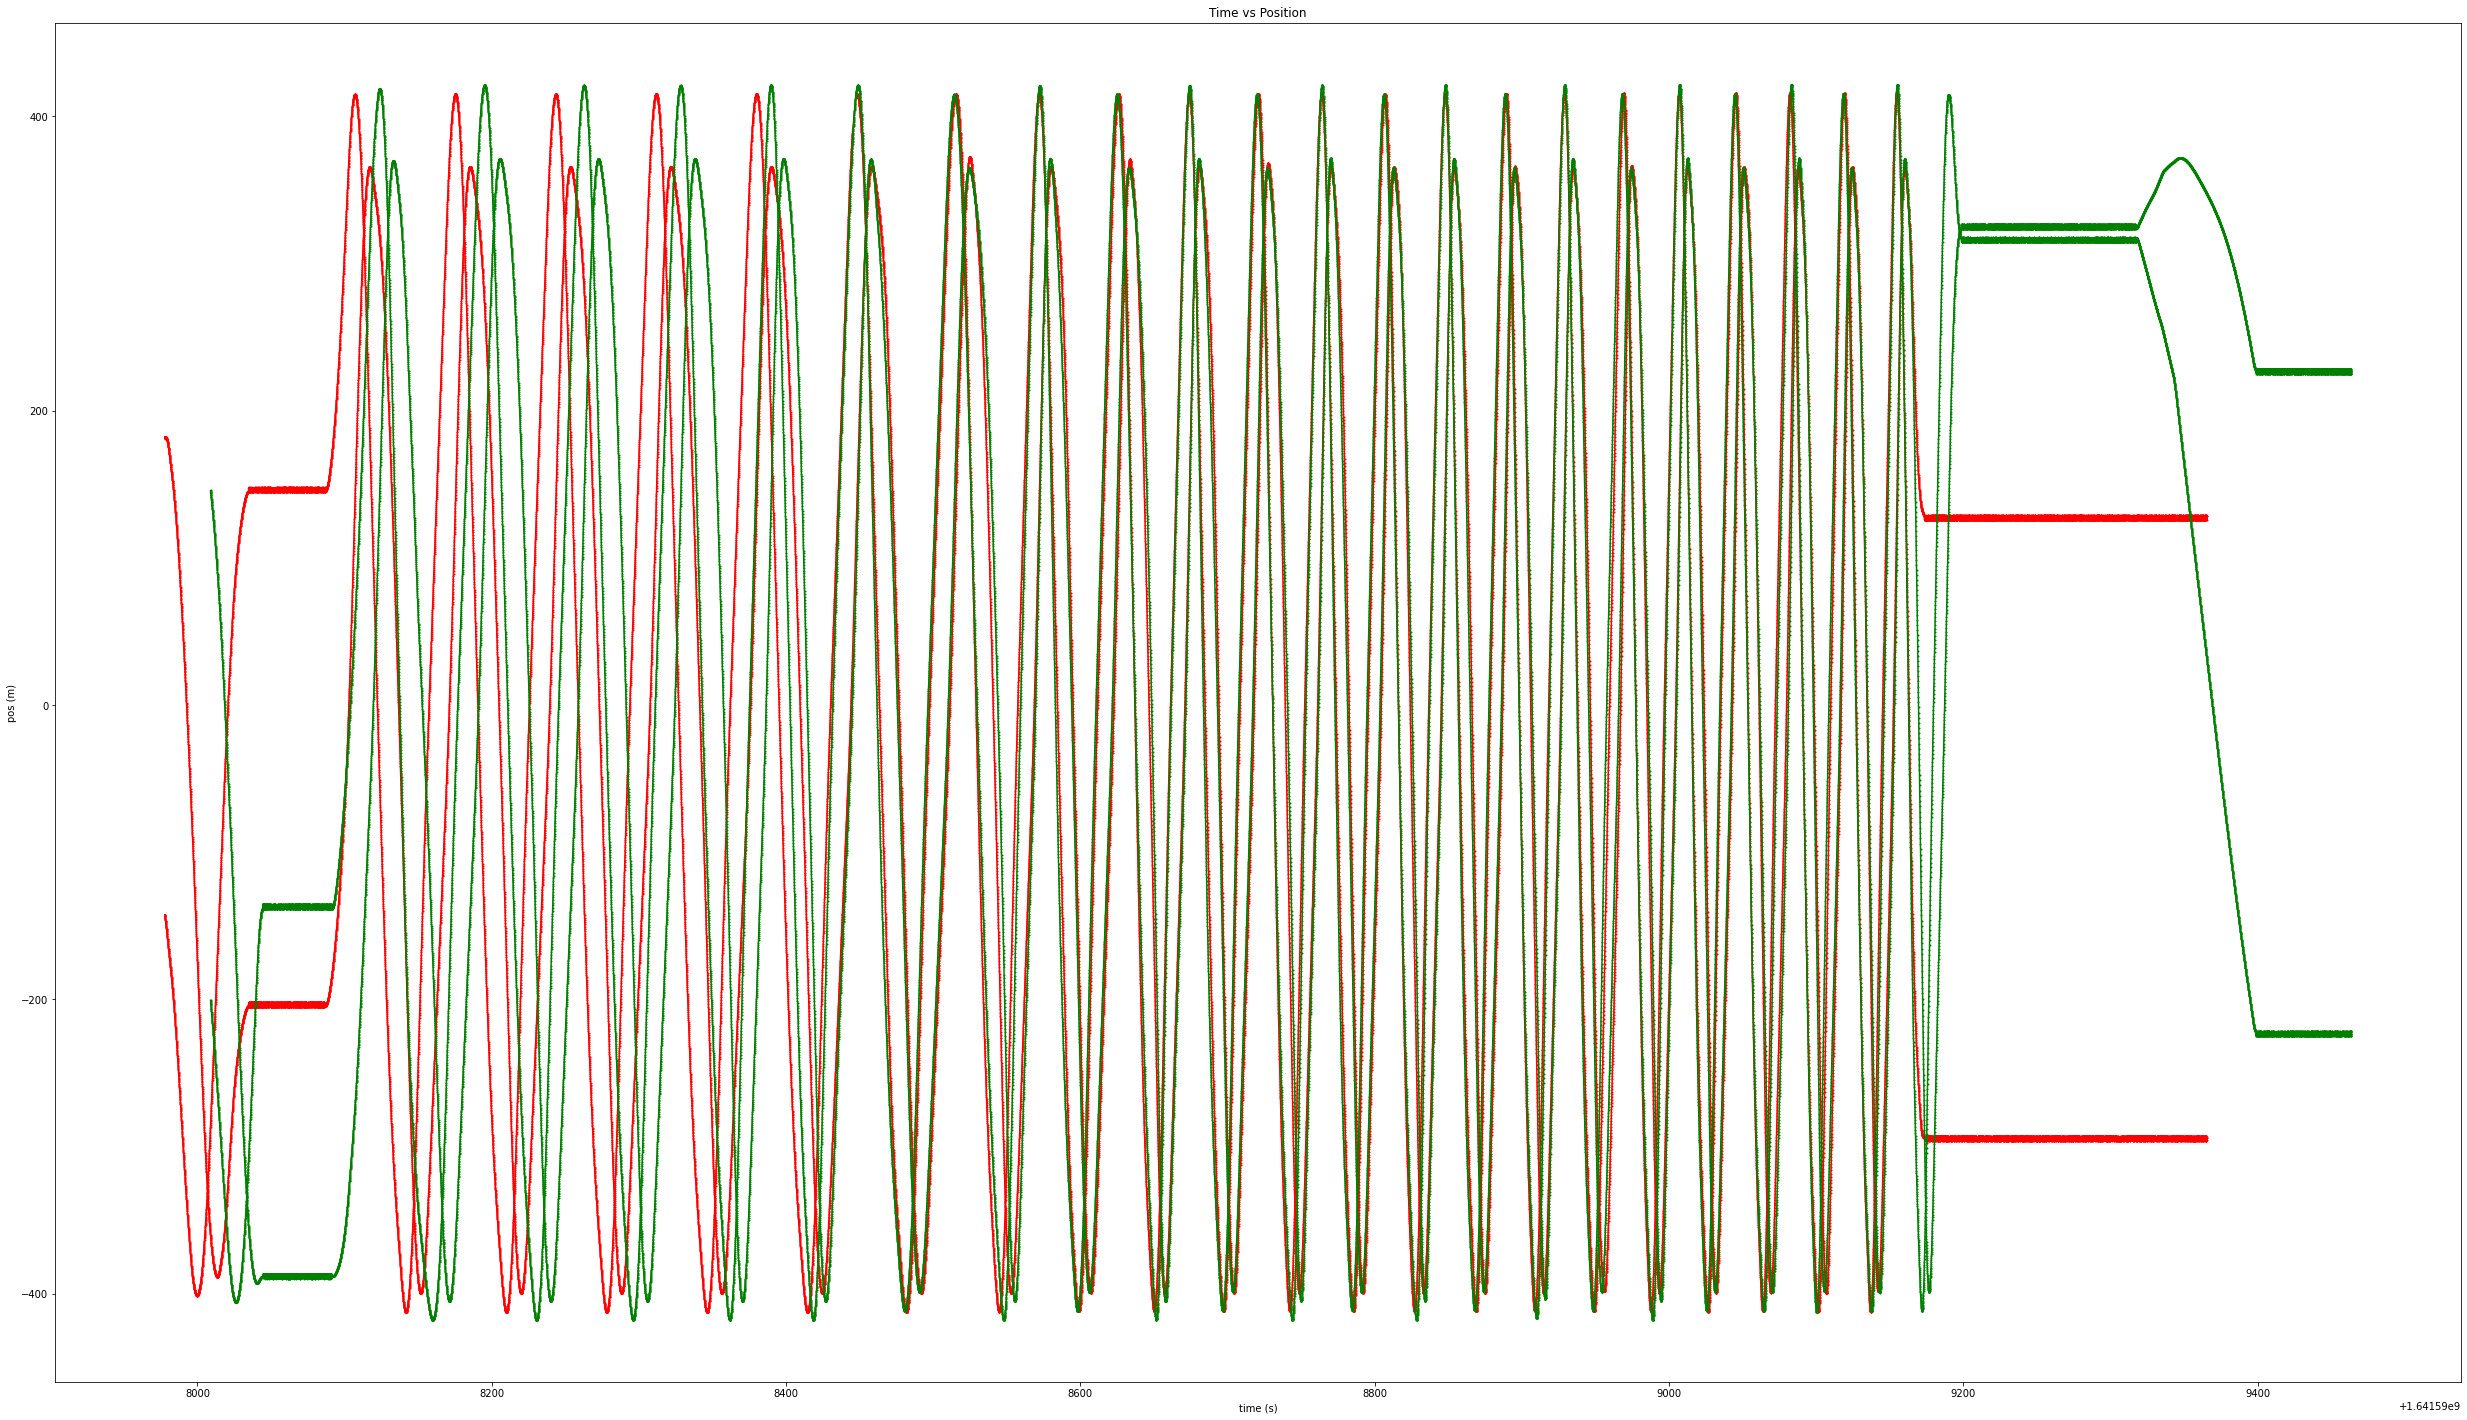

In [37]:
tum_bag_file = '../../data/RAW_ROSBAG/TUM/LVMS/LVMS-MULTI-FAST with Polimove/perception_bag_202201080026'
poli_bag_file = '../../data/RAW_ROSBAG/PoliMove/LVMS/LVMS-MULTI-FAST with TUM/20220107_lvms_multi_polimove_gps_only'
poli_topics = ['/novatel_top/bestgnsspos', '/novatel_top/bestvel']
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

tum_gps_messages, tum_vel_messages = read_bag_file(tum_bag_file, topics)
poli_gps_messages, poli_vel_messages = read_bag_file(poli_bag_file, poli_topics)

tum_local_odom = gen_local_odom(tum_gps_messages, tum_vel_messages, 'lvms')
poli_local_odom = gen_local_odom(poli_gps_messages, poli_vel_messages, 'lvms')

start_time = 1641598400.0
end_time = 1641599200.0
pruned_tum_odom = [cav_local_odom[i] for i, y in enumerate(tum_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
pruned_poli_odom = [poli_local_odom[i] for i, y in enumerate(poli_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
cx_pos = []
cy_pos = []
px_pos = []
py_pos = []
ctime  = []
ptime  = []
for odom in pruned_tum_odom:
    cx_pos.append(odom[1].pose.pose.position.x)
    cy_pos.append(odom[1].pose.pose.position.y)
    ctime.append(odom[0]*1e-9)
for odom in pruned_poli_odom:
    px_pos.append(odom[1].pose.pose.position.x)
    py_pos.append(odom[1].pose.pose.position.y)
    ptime.append(odom[0]*1e-9)

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(ctime, cx_pos, marker='o',color='r',linestyle='-', markersize = 1)
ax.plot(ctime, cy_pos, marker='o',color='r',linestyle='-', markersize = 1)

ax.plot(ptime, px_pos, marker='o',color='g',linestyle='-', markersize = 1)
ax.plot(ptime, py_pos, marker='o',color='g',linestyle='-', markersize = 1)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Time vs Position')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()


# write_merged_bag(ego_bag_file=cav_bag_file, 
#                  target_bag = '../../data/LOCAL_ODOM/TUM/LVMS/MULTI-FAST-POLI-GPS',
#                  ego_namespace='vehicle_3',
#                  obj_namespace='vehicle_5',
#                  ego_odom=pruned_cav_odom,
#                  obj_odom=pruned_poli_odom,
#                  start_time=start_time,
#                  end_time=end_time)
